# Regularização L1 e L2 em Redes Neurais

As regularizações **L1 (Lasso)** e **L2 (Ridge)** são técnicas usadas para reduzir o *overfitting* penalizando os pesos do modelo.

## L2 (Ridge)
Penaliza o **quadrado dos pesos**:  
$$
\mathcal{L}_{\text{L2}} = \mathcal{L}_{\text{erro}} + \lambda \sum_i w_i^2
$$

- Tende a reduzir os pesos, mas **raramente os zera**.  
- Gera modelos **mais estáveis** e **suaviza a fronteira de decisão**.  

---

## L1 (Lasso)
Penaliza o **valor absoluto dos pesos**:  
$$
\mathcal{L}_{\text{L1}} = \mathcal{L}_{\text{erro}} + \lambda \sum_i |w_i|
$$
- Pode **zerar** alguns pesos — promove **esparsidade**.  
- Ideal quando se acredita que **apenas algumas features são relevantes**.


## Elastic Net
Combina **L1 (Lasso)** e **L2 (Ridge)**, penalizando tanto o valor absoluto quanto o quadrado dos pesos:  

$$
\mathcal{L}_{\text{ElasticNet}} = \mathcal{L}_{\text{erro}} + \lambda_1 \sum_i |w_i| + \lambda_2 \sum_i w_i^2
$$

- Promove **esparsidade** (como L1) e **reduz variância** / estabiliza os pesos (como L2).  
- Útil quando há **features correlacionadas** e ainda se deseja **seleção de variáveis**.  
- Permite **balancear L1 e L2** ajustando os hiperparâmetros $\lambda_1$ e $\lambda_2$.


In [40]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

from sklearn.datasets import make_regression, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed=42
set_seed(seed)


## Classe para MLP

In [10]:
class FlexibleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.0, activation_fn=nn.ReLU, output_activation=None):
        super().__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_fn())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))
        if output_activation:
            layers.append(output_activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## Função para treinamento

In [11]:
def train_model(model, X_train,  y_train, X_val, y_val, reg_type=None, epochs=100, l1=0.0, l2=0.0, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        if reg_type == "l1" and l1:
          l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
          loss += l1 * l1_penalty

        elif reg_type == "l2" and l2:
          l2_penalty = sum(torch.sum(param ** 2) for param in model.parameters())
          loss += l2 * l2_penalty

        elif reg_type == "elasticnet" and l1 or l2:
          l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
          l2_penalty = sum(torch.sum(param ** 2) for param in model.parameters())
          loss += l1 * l1_penalty + l2 * l2_penalty

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss_epoch = criterion(val_pred, y_val)

        train_loss.append(loss.item())
        val_loss.append(val_loss_epoch.item())

    return {
          "train_loss": train_loss,
          "val_loss": val_loss,
          "model": model,
          "reg_type": reg_type if reg_type is not None else 'None',
          "l1": l1,
          "l2": l2
      }

## Funções para visualização de dados

In [12]:
def plot_losses_grid(histories, n_rows=2, n_cols=2, figsize=(12,8), log_scale=False):
    """
    Plota train e validation loss de múltiplos modelos em uma grade,
    incluindo número de camadas, número de pesos e intensidade da regularização.

    Args:
        histories: dict, chaves = nomes dos modelos, valores = dicts com 'train_loss', 'val_loss', 'model'
        n_rows: número de linhas da grade
        n_cols: número de colunas da grade
        figsize: tamanho da figura total
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # facilitar indexação

    for ax, (name, hist) in zip(axes, histories.items()):
        train_loss = hist['train_loss']
        val_loss = hist['val_loss']
        model = hist['model']
        reg_type = hist['reg_type']
        l1 = hist['l1']
        l2 = hist['l2']

        # Número de camadas ocultas (nn.Linear, exceto a saída)
        linear_layers = [l for l in model.network if isinstance(l, nn.Linear)]
        num_hidden_layers = len(linear_layers) - 1  # subtrai a camada de saída

        # Número de pesos totais
        num_params = sum(p.numel() for p in model.parameters())

        # Últimos valores de perda
        final_train_loss = train_loss[-1]
        final_val_loss = val_loss[-1]

        # Plot
        ax.plot(train_loss, label='Train Loss')
        ax.plot(val_loss, label='Validation Loss', linestyle='--')

        ax.set_title(
            f"{name}\n"
            f"Hidden layers: {num_hidden_layers} | Params: {num_params}\n"
            f"Reg: {reg_type} (L1={l1}, L2={l2})\n"
            f"Final Loss → Train: {final_train_loss:.4f} | Val: {final_val_loss:.4f}"
        )

        if log_scale:
            ax.set_yscale('log')

        ax.set_xlabel('Época')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # Remove eixos extras se houver menos modelos que subplots
    for ax in axes[len(histories):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_weight_distributions_grid(models, n_rows=2, n_cols=2, bins=30, figsize=(12,8)):
    """
    Plota a distribuição dos pesos de múltiplos modelos em uma grade.

    Args:
        models: dict, chaves = nomes dos modelos, valores = modelos PyTorch treinados
        n_rows: número de linhas da grade
        n_cols: número de colunas da grade
        bins: número de bins do histograma
        figsize: tamanho da figura total
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):
        all_weights = []
        for param_name, param in model.named_parameters():
            if 'weight' in param_name:  # apenas os pesos, ignora biases
                all_weights.extend(param.detach().cpu().numpy().flatten())

        ax.hist(all_weights, bins=bins, alpha=0.7)
        ax.set_title(f"Distribuição de pesos:\n Reg: {name}")
        ax.set_xlabel('Peso')
        ax.set_ylabel('Frequência')
        ax.grid(True)

    # Remove eixos extras se houver menos modelos que subplots
    for ax in axes[len(models):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

## Regressão Linear com Dataset Sintético

No primeiro exemplo, foi utilizado um dataset sintético gerado com a função make_regression do scikit-learn, que cria automaticamente um conjunto de dados para problemas de regressão linear. Foram geradas 100 amostras, cada uma com 10 variáveis independentes, e adicionado um ruído de 15 para simular incertezas nos dados. Esse tipo de dataset é ideal para testar modelos de aprendizado de máquina, pois permite controlar a complexidade do problema e verificar o comportamento de diferentes algoritmos. Após a geração, as features foram normalizadas com StandardScaler para que todas tivessem média zero e variância unitária, o que ajuda no treinamento de redes neurais. Em seguida, os dados foram divididos em conjuntos de treino e validação, e transformados em tensores do PyTorch, prontos para alimentar um modelo do tipo MLP (Multi-Layer Perceptron). Esse exemplo ilustra de forma prática como preparar um dataset para regressão e como organizar os dados para o treinamento de modelos neurais em PyTorch.


In [14]:
# Dataset simples
X, y = make_regression(n_samples=100, n_features=10, noise=15, random_state=seed)
# Adiciona algumas features irrelevantes

X = StandardScaler().fit_transform(X)
y = y.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)

In [15]:
input_size = X_train.shape[1]
hidden_sizes = [8, 8]
output_size = 1

l1_ex1 = 0.005
l2_ex1 = 0.005

l1_elastic_ex1 = 0.005
l2_elastic_ex1 = 0.005

histories_ex1 = {
    "Sem regularização": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                     X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500),
    "L1": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l1", l1=l1_ex1),
    "L2": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l2", l2=l2_ex1),
    "ElasticNet": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                              X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="elasticnet", l1=l1_elastic_ex1, l2=l2_elastic_ex1)
}

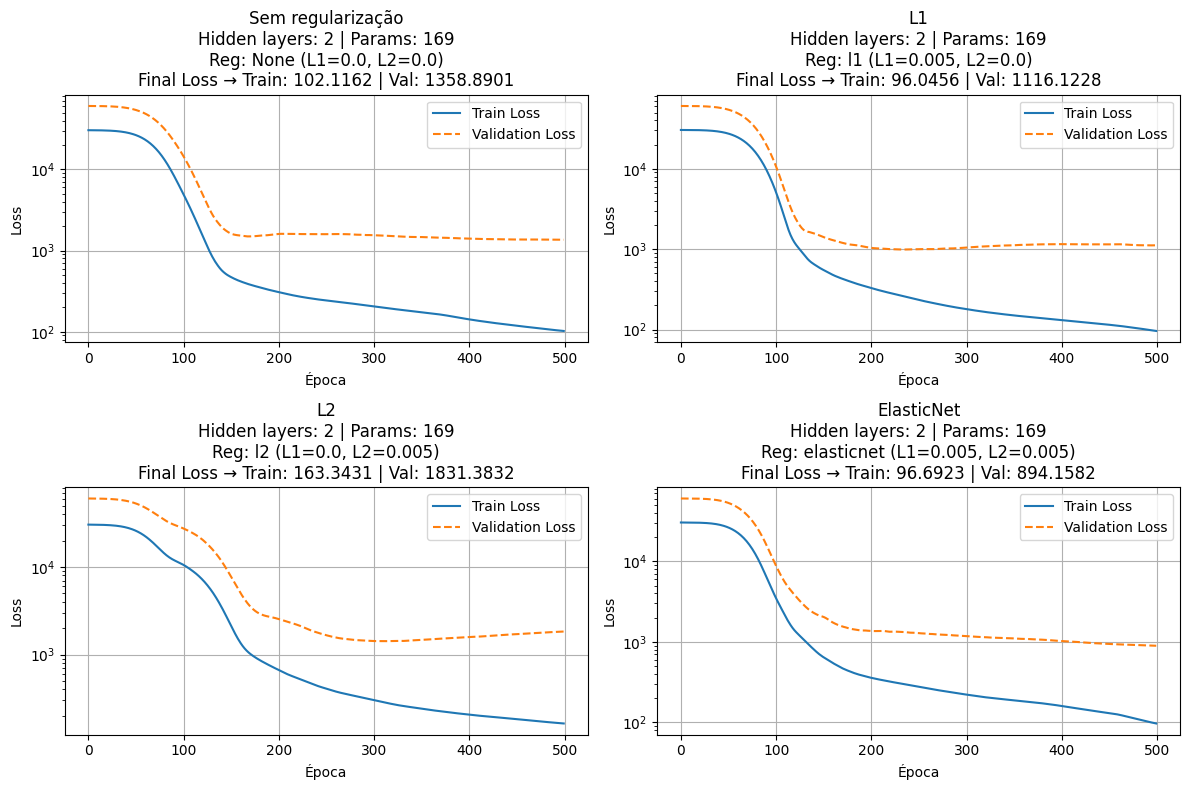

In [16]:
plot_losses_grid(histories_ex1, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Aumentando a complexidade da rede

In [18]:
input_size = X_train.shape[1]
hidden_sizes = [8, 32, 64, 128, 512, 128, 64, 32, 16, 8]
output_size = 1

l1_ex2 = 0.001
l2_ex2 = 0.001

l1_elastic_ex2 = 0.005
l2_elastic_ex2 = 0.005

histories_ex2 = {
    "Sem regularização": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                     X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500),
    "L1": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l1", l1=l1_ex2),
    "L2": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l2", l2=l2_ex2),
    "ElasticNet": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                              X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="elasticnet", l1=l1_elastic_ex2, l2=l2_elastic_ex2)
}

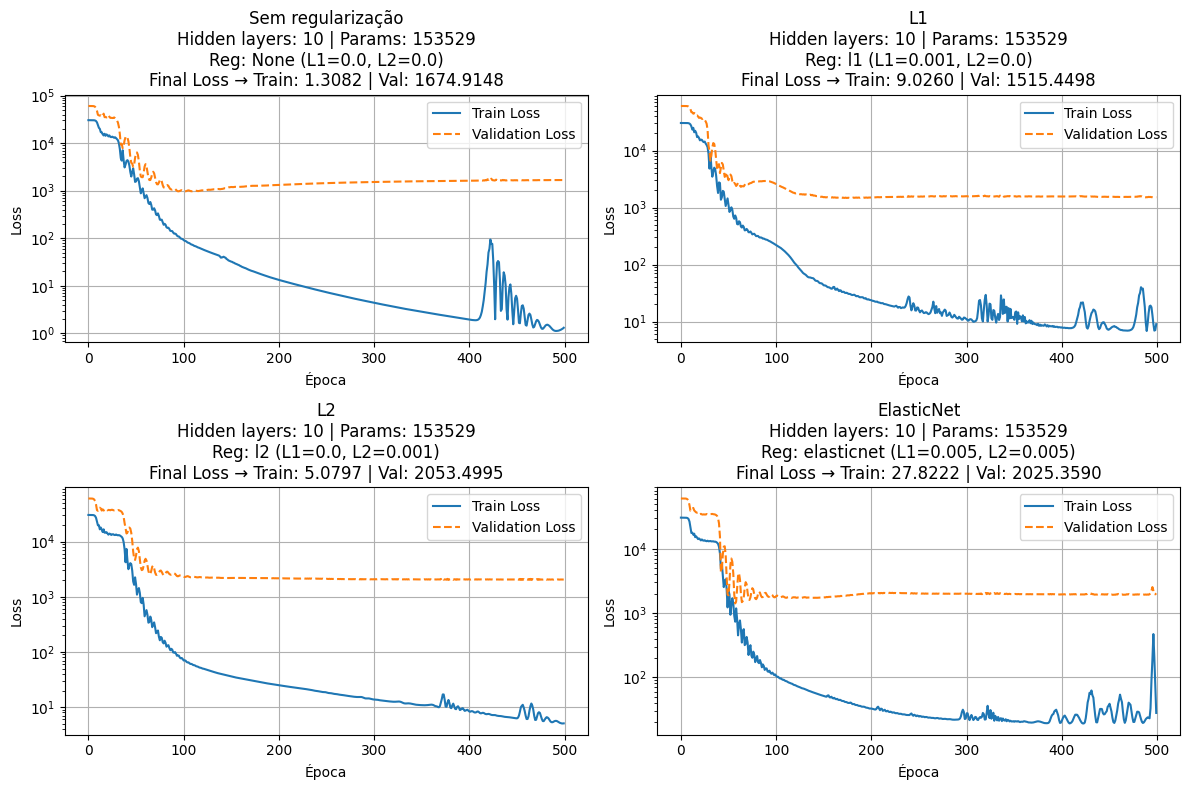

In [19]:
plot_losses_grid(histories_ex2, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Reduzindo a complexidade e aumentando a instensidade da penalidade :

In [20]:
input_size = X_train.shape[1]
hidden_sizes = [8, 8]
output_size = 1

l1_ex3 = 0.5
l2_ex3 = 0.5

l1_elastic_ex3 = 0.7
l2_elastic_ex3 = 0.7

histories_ex3 = {
    "Sem regularização": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                     X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500),
    "L1": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l1", l1=l1_ex3),
    "L2": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="l2", l2=l2_ex3),
    "ElasticNet": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                              X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=500, reg_type="elasticnet", l1=l1_elastic_ex3, l2=l2_elastic_ex3)
}

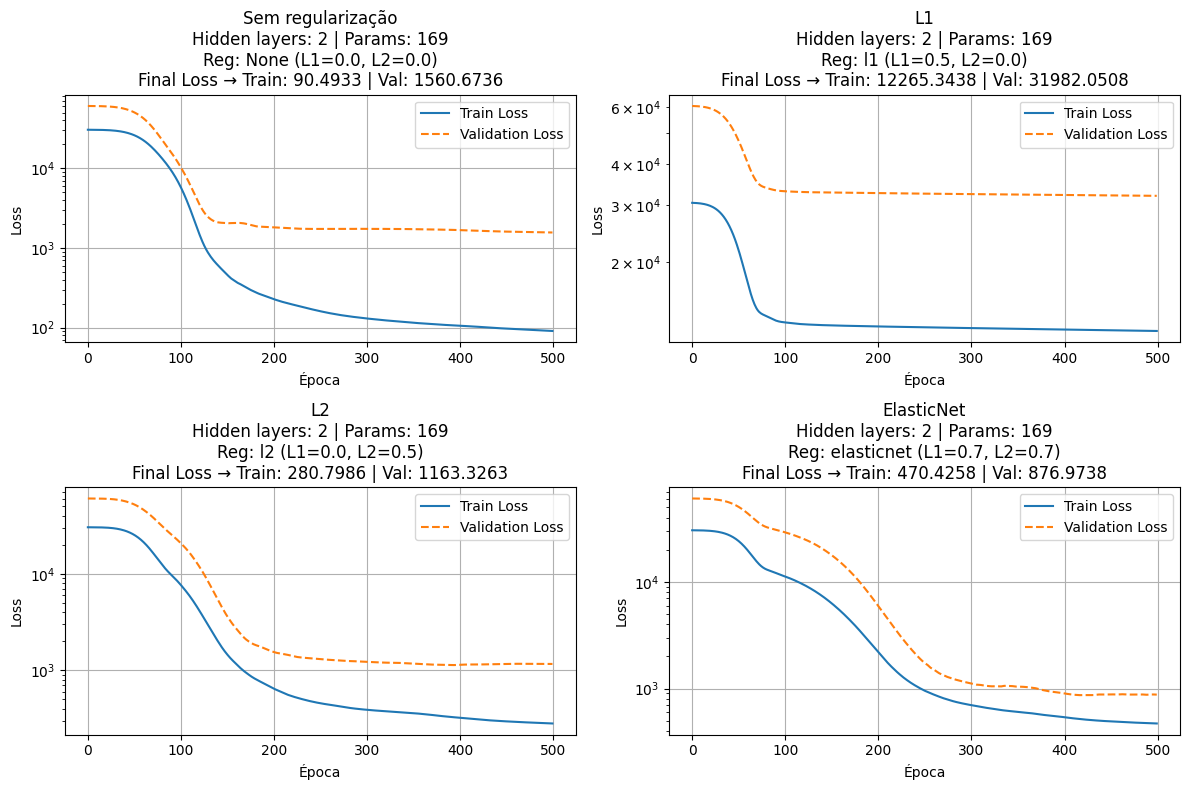

In [22]:
plot_losses_grid(histories_ex3, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Aumentando o conjunto de dados

In [23]:
# Dataset simples
n_samples = 1000
X_bigger, y_bigger = make_regression(n_samples=n_samples, n_features=10, noise=15, random_state=seed)
# Adiciona algumas features irrelevantes

X_bigger = StandardScaler().fit_transform(X_bigger)
y_bigger = y_bigger.reshape(-1, 1)

X_bigger_train, X_bigger_val, y_bigger_train, y_bigger_val = train_test_split(X_bigger, y_bigger, test_size=0.2, random_state=seed)
X_bigger_train = torch.tensor(X_bigger_train, dtype=torch.float32)
y_bigger_train = torch.tensor(y_bigger_train, dtype=torch.float32)
X_bigger_val   = torch.tensor(X_bigger_val, dtype=torch.float32)
y_bigger_val   = torch.tensor(y_bigger_val, dtype=torch.float32)

In [55]:
input_size = X_train.shape[1]
hidden_sizes = [8, 32, 64, 128, 512, 128, 64, 32, 16, 8]
output_size = 1


l1_ex4 = 0.07
l2_ex4 = 0.07

l1_elastic_ex4 = 0.05
l2_elastic_ex4 = 0.05


histories_ex4 = {
    "Sem regularização": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                     X_train=X_bigger_train, y_train=y_bigger_train, X_val=X_bigger_val, y_val=y_bigger_val, epochs=500),
    "L1": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_bigger_train, y_train=y_bigger_train, X_val=X_bigger_val, y_val=y_bigger_val, epochs=500, reg_type="l1", l1=l1_ex4),
    "L2": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                                    X_train=X_bigger_train, y_train=y_bigger_train, X_val=X_bigger_val, y_val=y_bigger_val, epochs=500, reg_type="l2", l2=l2_ex4),
    "ElasticNet": train_model(FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
                              X_train=X_bigger_train, y_train=y_bigger_train, X_val=X_bigger_val, y_val=y_bigger_val, epochs=500, reg_type="elasticnet", l1=l1_elastic_ex4, l2=l2_elastic_ex4)
}

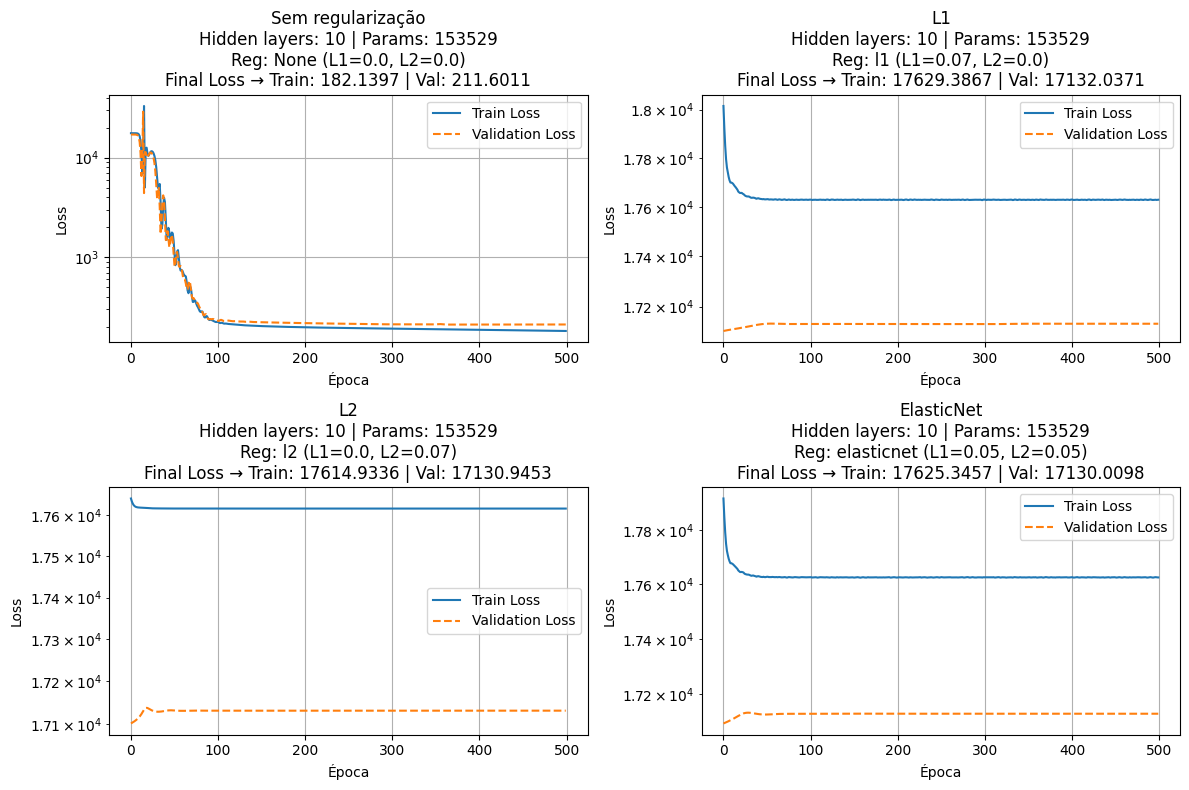

In [57]:
plot_losses_grid(histories_ex4, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Reduzindo o conjunto de dados e intensidade da penalidade



In [26]:
# Dataset médio
n_samples = 500
X_medium, y_medium = make_regression(n_samples=n_samples, n_features=10, noise=15, random_state=42)

X_medium = StandardScaler().fit_transform(X_medium)
y_medium = y_medium.reshape(-1, 1)

# Divide em treino e validação
X_medium_train, X_medium_val, y_medium_train, y_medium_val = train_test_split(
    X_medium, y_medium, test_size=0.2, random_state=seed
)

# Converte para tensores PyTorch
X_medium_train = torch.tensor(X_medium_train, dtype=torch.float32)
y_medium_train = torch.tensor(y_medium_train, dtype=torch.float32)
X_medium_val   = torch.tensor(X_medium_val, dtype=torch.float32)
y_medium_val   = torch.tensor(y_medium_val, dtype=torch.float32)

In [27]:
input_size = X_medium_train.shape[1]
hidden_sizes = [8, 32, 64, 128, 512, 128, 64, 32, 16, 8] #10
output_size = 1

# Hiperparâmetros de regularização
l1_ex5 = 0.001
l2_ex5 = 0.001

l1_elastic_ex5 = 0.005
l1_elastic_ex5 = 0.005

# Treinamento dos modelos com o dataset médio
histories_ex5 = {
    "Sem regularização": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500
    ),
    "L1": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="l1", l1=l1_ex5
    ),
    "L2": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="l2", l2=l2_ex5
    ),
    "ElasticNet": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="elasticnet", l1=l1_elastic_ex5, l2=l2_elastic_ex5
    )
}

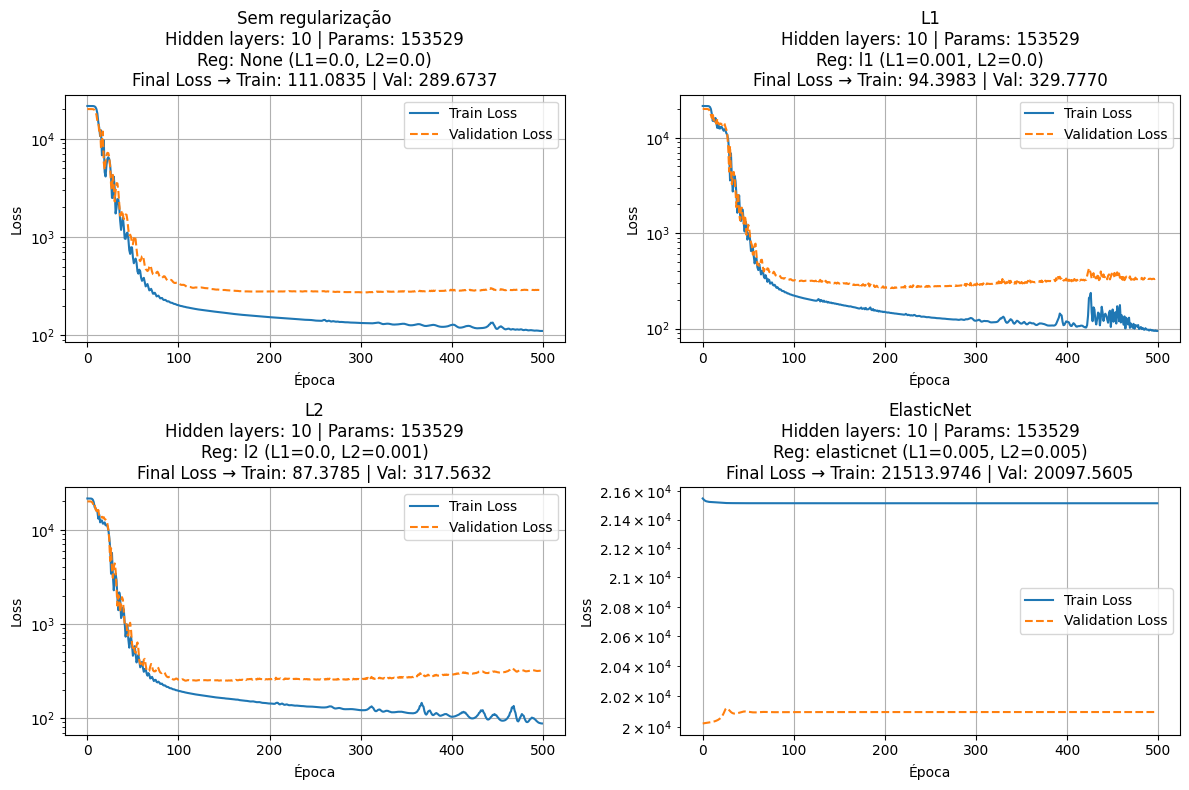

In [28]:
plot_losses_grid(histories_ex5, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Aumentando a intensidade da penalidade em 10x

In [29]:
input_size = X_medium_train.shape[1]
hidden_sizes = [8, 32, 64, 128, 512, 128, 64, 32, 16, 8]
output_size = 1

# Hiperparâmetros de regularização

l1_ex6 = 0.01
l2_ex6 = 0.01

l1_elastic_ex6 = 0.05
l2_elastic_ex6 = 0.05


# Treinamento dos modelos com o dataset médio
histories_ex6 = {
    "Sem regularização": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500
    ),
    "L1": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="l1", l1=l1_ex6
    ),
    "L2": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="l2", l2=l2_ex6
    ),
    "ElasticNet": train_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_medium_train, y_train=y_medium_train,
        X_val=X_medium_val, y_val=y_medium_val,
        epochs=500, reg_type="elasticnet", l1=l1_elastic_ex6, l2=l2_elastic_ex6
    )
}

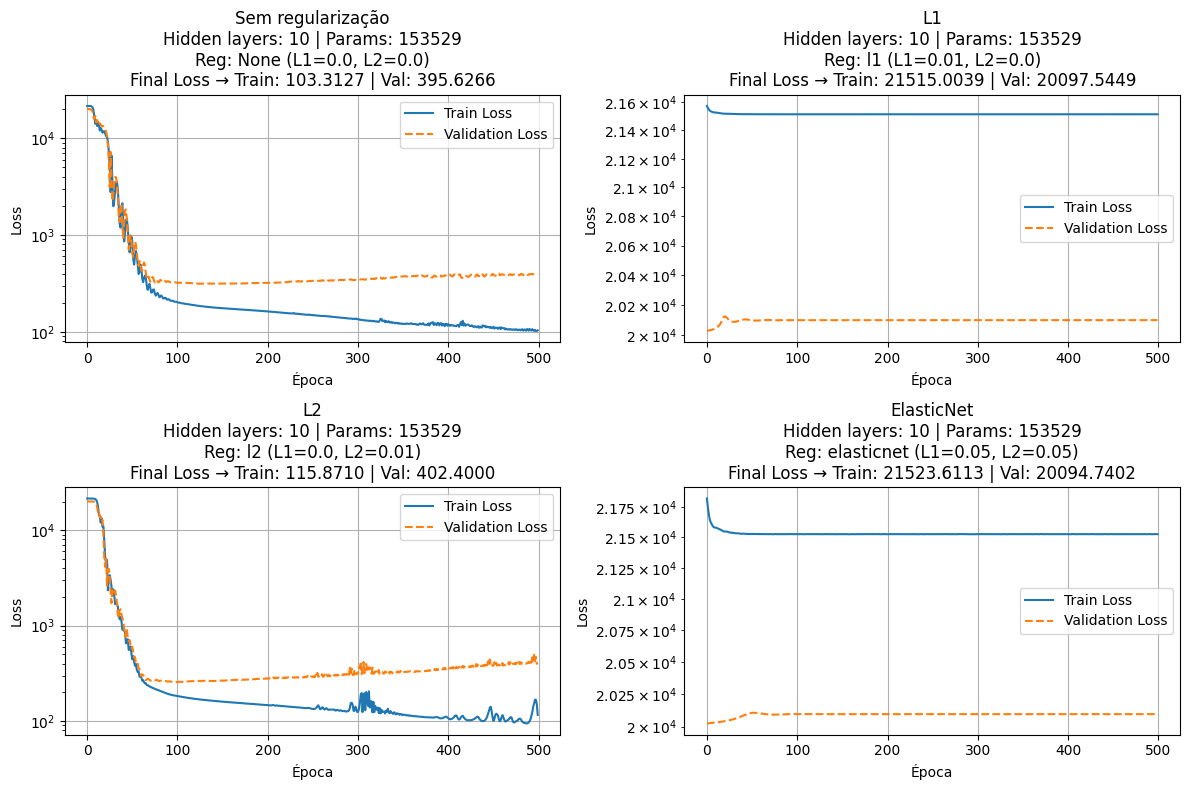

In [30]:
plot_losses_grid(histories_ex6, n_rows=2, n_cols=2, figsize=(12,8), log_scale=True)

## Exemplo Wine Dataset

O Wine Dataset (conjunto de dados do vinho) faz parte da biblioteca sklearn.datasets.
Ele contém características químicas de vinhos provenientes de 3 variedades diferentes de uvas cultivadas na região italiana.

O objetivo é classificar o tipo de vinho com base nessas propriedades químicas.

In [37]:
data = load_wine()

X_wine, y_wine = data.data, data.target

# Cria DataFrame
df = pd.DataFrame(X_wine, columns=data.feature_names)
df['target'] = y_wine

print(f"Shape: {df.shape}")
df.head()


Shape: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [31]:
scaler_wine = StandardScaler()
X_wine = scaler_wine.fit_transform(X_wine)

X_train_wine, X_val_wine, y_train_wine, y_val_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=seed
)

# Converter para tensores
X_train_wine = torch.tensor(X_train_wine, dtype=torch.float32)
X_val_wine = torch.tensor(X_val_wine, dtype=torch.float32)
y_train_wine = torch.tensor(y_train_wine, dtype=torch.long)
y_val_wine = torch.tensor(y_val_wine, dtype=torch.long)

In [32]:
def train_wine_model(model, X_train, y_train, X_val, y_val, reg_type=None, epochs=100, l1=0.0, l2=0.0, lr=0.01):
    """
    Treina o modelo com suporte a L1, L2 e ElasticNet.
    Funciona tanto para regressão quanto para classificação multiclasses.

    Retorna um dicionário com train_loss, val_loss, modelo e parâmetros de regularização.
    """
    # Detecta automaticamente classificação ou regressão
    outputs_sample = model(X_train[:1])
    is_classification = y_train.ndim == 1 and outputs_sample.shape[1] > 1

    criterion = nn.CrossEntropyLoss() if is_classification else nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # L2 via weight_decay
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)

        # Ajuste para regressão
        if isinstance(criterion, nn.MSELoss) and outputs.shape != y_train.shape:
            y_train_target = y_train.view_as(outputs)
        else:
            y_train_target = y_train

        loss = criterion(outputs, y_train_target)

        # L1 manual
        if reg_type in ("l1", "elasticnet") and l1 > 0:
            l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
            loss += l1 * l1_penalty

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            if isinstance(criterion, nn.MSELoss) and val_outputs.shape != y_val.shape:
                y_val_target = y_val.view_as(val_outputs)
            else:
                y_val_target = y_val
            val_loss_val = criterion(val_outputs, y_val_target)
            val_loss.append(val_loss_val.item())

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "model": model,
        "reg_type": reg_type if reg_type is not None else 'None',
        "l1": l1,
        "l2": l2
    }


In [33]:
# Parâmetros do modelo
input_size = X_train_wine.shape[1]
hidden_sizes = [8, 32, 64, 128, 512, 128, 64, 32, 16, 8, 8, 32, 64, 128, 512, 128, 64, 32, 16, 8, 8, 32, 64, 128, 512, 128, 64, 32, 16, 8] #30
output_size = 3  # 3 classes

# Regularização
l1_wine_ex1 = 0.001
l2_wine_ex1 = 0.001
l1_elastic_wine_ex1 = 0.005
l2_elastic_wine_ex1 = 0.005

# Históricos de treinamento
histories_wine_ex1 = {
    "Sem regularização": train_wine_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_train_wine, y_train=y_train_wine,
        X_val=X_val_wine, y_val=y_val_wine,
        epochs=500
    ),
    "L1": train_wine_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_train_wine, y_train=y_train_wine,
        X_val=X_val_wine, y_val=y_val_wine,
        epochs=500, reg_type="l1", l1=l1_wine_ex1
    ),
    "L2": train_wine_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_train_wine, y_train=y_train_wine,
        X_val=X_val_wine, y_val=y_val_wine,
        epochs=500, reg_type="l2", l2=l2_wine_ex1
    ),
    "ElasticNet": train_wine_model(
        FlexibleMLP(input_size, hidden_sizes, output_size, output_activation=nn.Identity),
        X_train=X_train_wine, y_train=y_train_wine,
        X_val=X_val_wine, y_val=y_val_wine,
        epochs=500, reg_type="elasticnet", l1=l1_elastic_wine_ex1, l2=l2_elastic_wine_ex1
    )
}

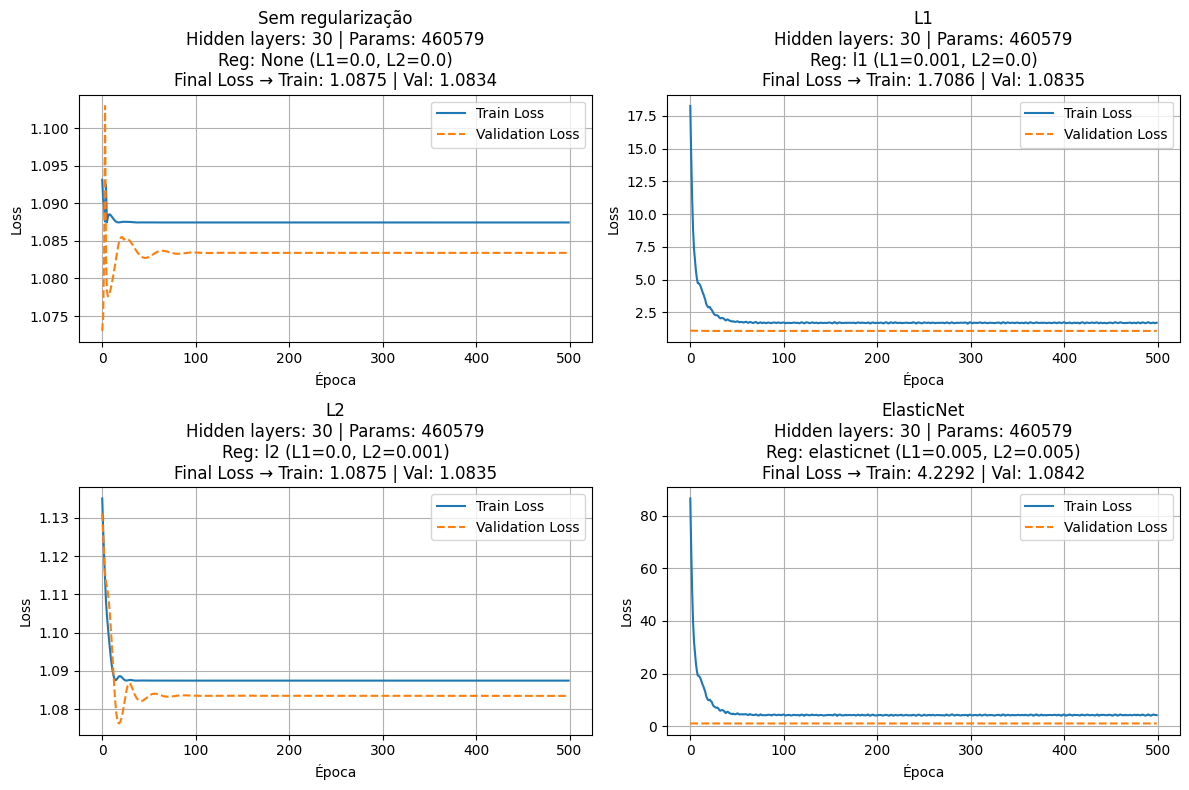

In [34]:
plot_losses_grid(histories_wine_ex1, n_rows=2, n_cols=2, figsize=(12,8))

## Exemplo MNIST

In [45]:
class FlexibleMLP_MNIST(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.0, activation_fn=nn.ReLU, output_activation=None):
        super().__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_fn())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))
        if output_activation:
            layers.append(output_activation())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten (64, 1, 28, 28) → (64, 784)
        return self.network(x)


In [46]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Dividir treino/validação
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_dataset, val_dataset = random_split(mnist_data, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [47]:
def train_mnist_model(model, train_loader, val_loader, reg_type=None, epochs=10, l1=0.0, l2=0.0, lr=0.001):
    """
    Treina o modelo com suporte a L1, L2 e ElasticNet no dataset MNIST.
    Retorna um dicionário com histórico, modelo e parâmetros de regularização.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # L1 manual
            if reg_type in ("l1", "elasticnet") and l1 > 0:
                l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
                loss += l1 * l1_penalty

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        # Validação
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                outputs = model(X_val)
                val_loss_batch = criterion(outputs, y_val)
                total_val_loss += val_loss_batch.item()
        val_loss.append(total_val_loss / len(val_loader))

        print(f"Época [{epoch+1}/{epochs}] - Treino: {train_loss[-1]:.4f} | Validação: {val_loss[-1]:.4f}")

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "model": model,
        "reg_type": reg_type if reg_type is not None else 'None',
        "l1": l1,
        "l2": l2
    }


In [48]:
input_size = 28 * 28
hidden_sizes = [256, 128, 64]
output_size = 10

histories_mnist_ex1 = {
    "Sem regularização": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, epochs=5
    ),
    "L1": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="l1", l1=1e-5, epochs=10
    ),
    "L2": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="l2", l2=1e-4, epochs=10
    ),
    "ElasticNet": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="elasticnet", l1=1e-5, l2=1e-4, epochs=10
    ),
}


Época [1/5] - Treino: 0.4595 | Validação: 0.2731
Época [2/5] - Treino: 0.2039 | Validação: 0.1874
Época [3/5] - Treino: 0.1413 | Validação: 0.1391
Época [4/5] - Treino: 0.1121 | Validação: 0.1581
Época [5/5] - Treino: 0.0943 | Validação: 0.1166
Época [1/5] - Treino: 0.5221 | Validação: 0.2680
Época [2/5] - Treino: 0.2555 | Validação: 0.1845
Época [3/5] - Treino: 0.1964 | Validação: 0.2014
Época [4/5] - Treino: 0.1692 | Validação: 0.1182
Época [5/5] - Treino: 0.1485 | Validação: 0.1068
Época [1/5] - Treino: 0.4795 | Validação: 0.2772
Época [2/5] - Treino: 0.2142 | Validação: 0.1832
Época [3/5] - Treino: 0.1482 | Validação: 0.1756
Época [4/5] - Treino: 0.1182 | Validação: 0.1450
Época [5/5] - Treino: 0.1014 | Validação: 0.1469
Época [1/5] - Treino: 0.5399 | Validação: 0.2606
Época [2/5] - Treino: 0.2525 | Validação: 0.1814
Época [3/5] - Treino: 0.1958 | Validação: 0.1529
Época [4/5] - Treino: 0.1620 | Validação: 0.1311
Época [5/5] - Treino: 0.1470 | Validação: 0.1205


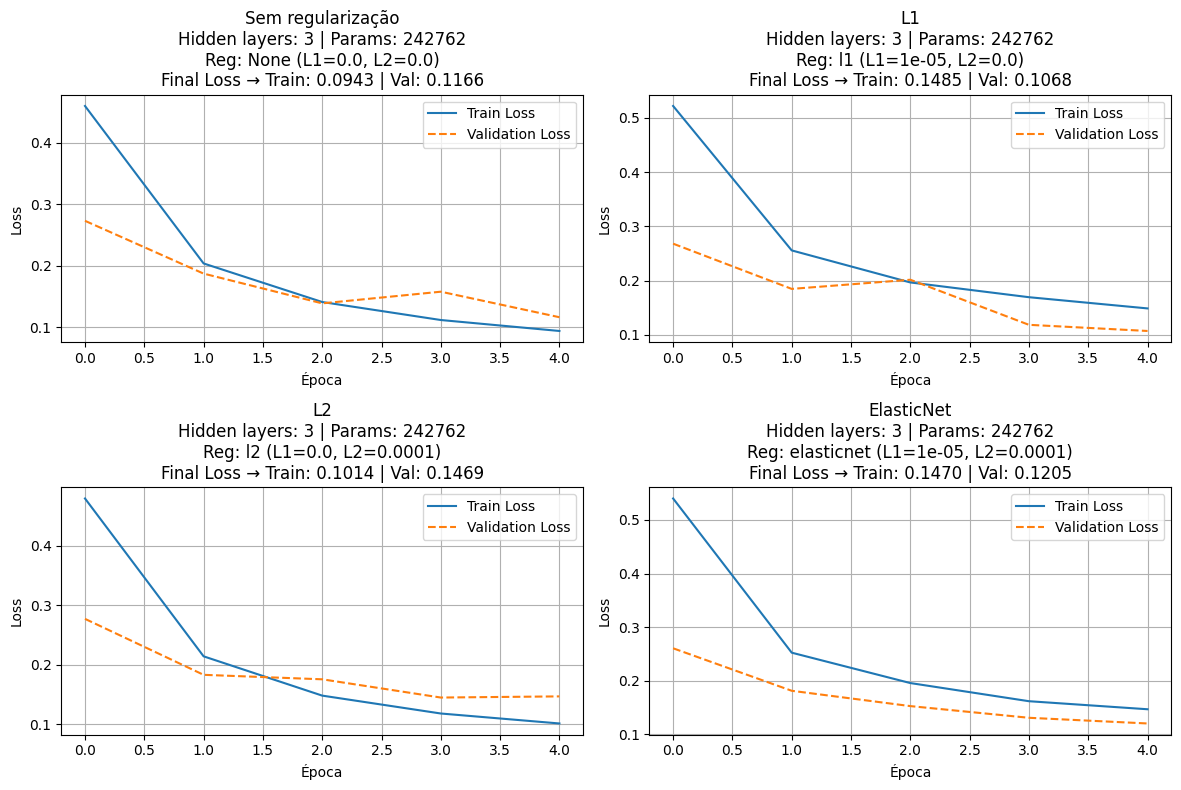

In [49]:
plot_losses_grid(histories_mnist_ex1, n_rows=2, n_cols=2, figsize=(12,8))

In [50]:
input_size = 28 * 28
hidden_sizes = [256, 128, 64, 256, 128, 64, 256, 128, 64, 256, 128, 64, 256, 128, 64] #15
output_size = 10

histories_mnist_ex2 = {
    "Sem regularização": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, epochs=5
    ),
    "L1": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="l1", l1=1e-5, epochs=10
    ),
    "L2": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="l2", l2=1e-4, epochs=10
    ),
    "ElasticNet": train_mnist_model(
        FlexibleMLP_MNIST(input_size, hidden_sizes, output_size),
        train_loader, val_loader, reg_type="elasticnet", l1=1e-5, l2=1e-4, epochs=10
    ),
}


Época [1/5] - Treino: 1.2860 | Validação: 0.5634
Época [2/5] - Treino: 0.4291 | Validação: 0.3739
Época [3/5] - Treino: 0.2717 | Validação: 0.2893
Época [4/5] - Treino: 0.3313 | Validação: 0.2608
Época [5/5] - Treino: 0.2294 | Validação: 0.2047
Época [1/10] - Treino: 2.3145 | Validação: 2.3015
Época [2/10] - Treino: 2.3025 | Validação: 2.3015
Época [3/10] - Treino: 2.3022 | Validação: 2.3015
Época [4/10] - Treino: 2.3020 | Validação: 2.3015
Época [5/10] - Treino: 2.3020 | Validação: 2.3016
Época [6/10] - Treino: 2.3020 | Validação: 2.3015
Época [7/10] - Treino: 2.3020 | Validação: 2.3015
Época [8/10] - Treino: 2.3020 | Validação: 2.3016
Época [9/10] - Treino: 2.3020 | Validação: 2.3016
Época [10/10] - Treino: 2.3019 | Validação: 2.3015
Época [1/10] - Treino: 2.3016 | Validação: 2.3019
Época [2/10] - Treino: 2.3015 | Validação: 2.3017
Época [3/10] - Treino: 2.3013 | Validação: 2.3016
Época [4/10] - Treino: 2.3013 | Validação: 2.3016
Época [5/10] - Treino: 2.3013 | Validação: 2.3016
Époc

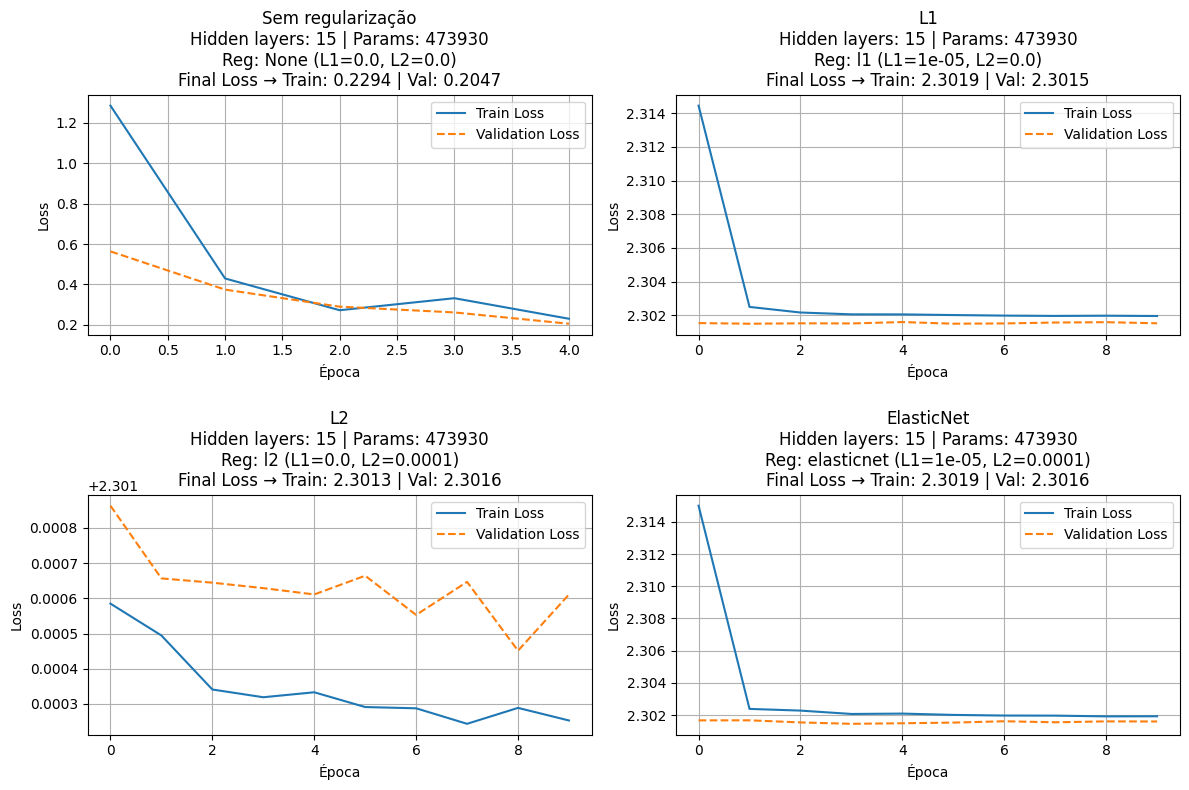

In [52]:
plot_losses_grid(histories_mnist_ex2, n_rows=2, n_cols=2, figsize=(12,8))